# Guided synthesis for TIO4

## Imports and installations

In [35]:
# !pip install numpy==1.26.4
# !pip install pymoo==0.6.1.1
# !pip install nbformat==5.10.4
# !pip install pandas==1.5.3
# !pip install seaborn==0.13.2
# !pip install openpyxl==3.1.2
# !pip install matplotlib==3.8.4
# !pip install scikit-learn==1.5.0
# !pip install shap==0.45.0
# !pip install xgboost==1.6.2

  Using cached pymoo-0.6.1.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (5.1 kB)
  Using cached autograd-1.6.2-py3-none-any.whl.metadata (706 bytes)
  Using cached cma-3.2.2-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached alive_progress-3.1.5-py3-none-any.whl.metadata (68 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached about_time-4.2.1-py3-none-any.whl.metadata (13 kB)
  Using cached grapheme-0.6.0-py3-none-any.whl
  Using cached wrapt-1.16.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.6 kB)
Using cached pymoo-0.6.1.1-cp311-cp311-macosx_10_9_universal2.whl (1.6 MB)
Using cached cma-3.2.2-py2.py3-none-any.whl (249 kB)
Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
Using cached alive_progress-3.1.5-py3-none-any.whl (75 kB)
Using cached about_time-4.2.1-py3-none-any.whl (13 kB)
Using cached Deprecated-1.2.

In [1]:
import numpy as np
import utils.FILibExcel as FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import xgboost as xgb 
import shap

/Users/alexglushko/ProgramProj/guided-synthesis-tio4/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Processing

In [2]:
excel_path = r"dataset/titanium sols.xlsx"
artifacts_path = r"artifacts/"

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table3"]['dataframe']
df = df.fillna(value=0)


worksheet name: Experiment_data_3
tables in worksheet: 1
table name: Table3


In [4]:
df.shape

(64, 8)

In [5]:
df.head()

,Composition mixtures,"t, °С","t, min","с(acid), M","с(Ti4+), M","d, nm","Contents, %","Stability of sols, days"
0,H2O + HNO3 + TiIPO + ButOH,45,60,4.0,0.50,618.500,100.0,16.0
1,H2O + HNO3 + TiIPO + ButOH,80,10,4.0,0.50,978.100,100.0,16.0
2,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.50,2.000,100.0,90.0
3,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.47,2.628,100.0,60.0
4,H2O + HNO3 + TiIPO + IPOОН,50,20,4.0,0.20,1712.000,100.0,16.0


In [6]:
df.drop('Composition mixtures', axis=1).astype('float').describe().T

,count,mean,std,min,25%,50%,75%,max
"t, °С",64.0,59.828125,21.207632,20.00,45.00000,60.00,80.000,93.00
"t, min",64.0,35.125000,31.555192,8.00,11.75000,20.00,60.000,130.00
"с(acid), M",64.0,1.174375,1.571372,0.10,0.10000,0.28,2.095,4.00
"с(Ti4+), M",64.0,0.392813,0.191348,0.14,0.17000,0.41,0.600,0.62
"d, nm",64.0,790.852641,957.557550,0.70,2.14675,4.43,2000.000,3096.00
"Contents, %",64.0,96.706250,15.103987,0.50,100.00000,100.00,100.000,100.00
"Stability of sols, days",64.0,24.859375,26.957561,0.00,2.00000,13.00,40.000,90.00


In [7]:
df.dtypes

Composition mixtures        object
t, °С                        int64
t, min                       int64
с(acid), M                 float64
с(Ti4+), M                 float64
d, nm                      float64
Contents, %                float64
Stability of sols, days    float64
dtype: object

In [8]:
composition_mixtures_dict = {
    'H2O + HNO3 + TiIPO + ButOH': 1,
    'H2O + HNO3 + TiIPO + IPOОН': 2,
    'H2O + HNO3 + ТiBut + ButOH': 3,
    'H2O + TiOSO₄´xH2SO4´yH2O': 4,
}
df = df.replace(composition_mixtures_dict)

In [9]:
df = df.rename(columns={'t, °С': 'T, °С'})
df = df.rename(columns={'с(Ti4+), M': r'с(Ti$^{4+}$), M'})
df = df.rename(columns={'Composition mixtures': 'Mixture composition'})
X = df.drop(['Contents, %', 'd, nm', 'Stability of sols, days'], axis=1)
y_days = df['Stability of sols, days']
y_d = df['d, nm']
y_content = df['Contents, %']

## Draw bar plots

In [10]:
new_col = []
for elem in df['d, nm']:
    if elem > 2000:
        new_col.append(5)
    elif elem > 1000:
        new_col.append(4)
    elif elem > 400:
        new_col.append(3)
    elif elem > 2:
        new_col.append(2)
    elif elem > 1:
        new_col.append(1)
    else:
        new_col.append(0)
df['d_categorical'] = new_col

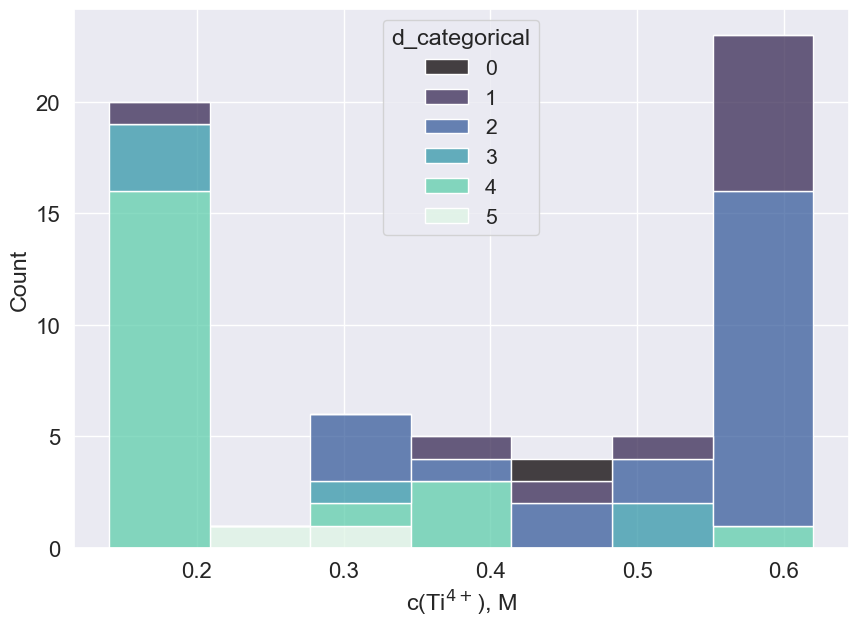

<Figure size 640x480 with 0 Axes>

In [11]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.tick_params(axis='both', labelsize=16)
sns.histplot(df, x=r'с(Ti$^{4+}$), M', hue='d_categorical', multiple="stack", palette='mako')

plt.show()
plt.savefig(artifacts_path + 'Ti4Distribution.png', format='png', dpi=600)
plt.show()

In [12]:
from matplotlib.offsetbox import AnchoredText

def draw_hists(df, hue, name, hue_order=None, discrete_save=False):
    fontdict={
        'weight': 'bold',
        'size': 20,
    }
    fig, axes = plt.subplots(ncols=2, nrows=3)
    fig.set_size_inches(20, 25)
    sns.set(font_scale=1.4)
    titles = ['a', 'b', 'c', 'd', 'e']
    index = 0
    if discrete_save:
        plt.show()

    for col, ax in zip(['T, °С', 't, min', 'с(acid), M', r'с(Ti$^{4+}$), M', 'Mixture composition'], axes.flat):
        if discrete_save:
            plt.gcf().set_size_inches(10, 7)
            ax = plt.subplot()
        else:
            txt = AnchoredText(titles[index], loc="lower right", pad=0.25, borderpad=0, prop=dict(fontsize="large"))
            ax.add_artist(txt)
        ax.tick_params(axis='both', labelsize=20, width=5)
        ax.set_xlabel(col, fontdict=fontdict)
        ax.set_ylabel('Count', fontdict=fontdict)
        if col == 'Mixture composition':
            ax.set_xticks([1, 2, 3, 4])
            sns.histplot(df, x=col, hue=hue, hue_order=hue_order, multiple="stack", palette='mako', ax=ax, discrete=True, shrink=.7)
        else:
            sns.histplot(df, x=col, hue=hue, hue_order=hue_order, multiple="stack", palette='mako', ax=ax)
        index += 1
        if discrete_save:
            plt.savefig(artifacts_path + f'second_stage_{name}_{col}.png', format='png', dpi=600)
            plt.show()

    fig.subplots_adjust(hspace=0.15)
    axes[-1, -1].axis('off')
    plt.savefig(artifacts_path + f'second_stage_{name}.png', format='png', dpi=600)
    plt.show()


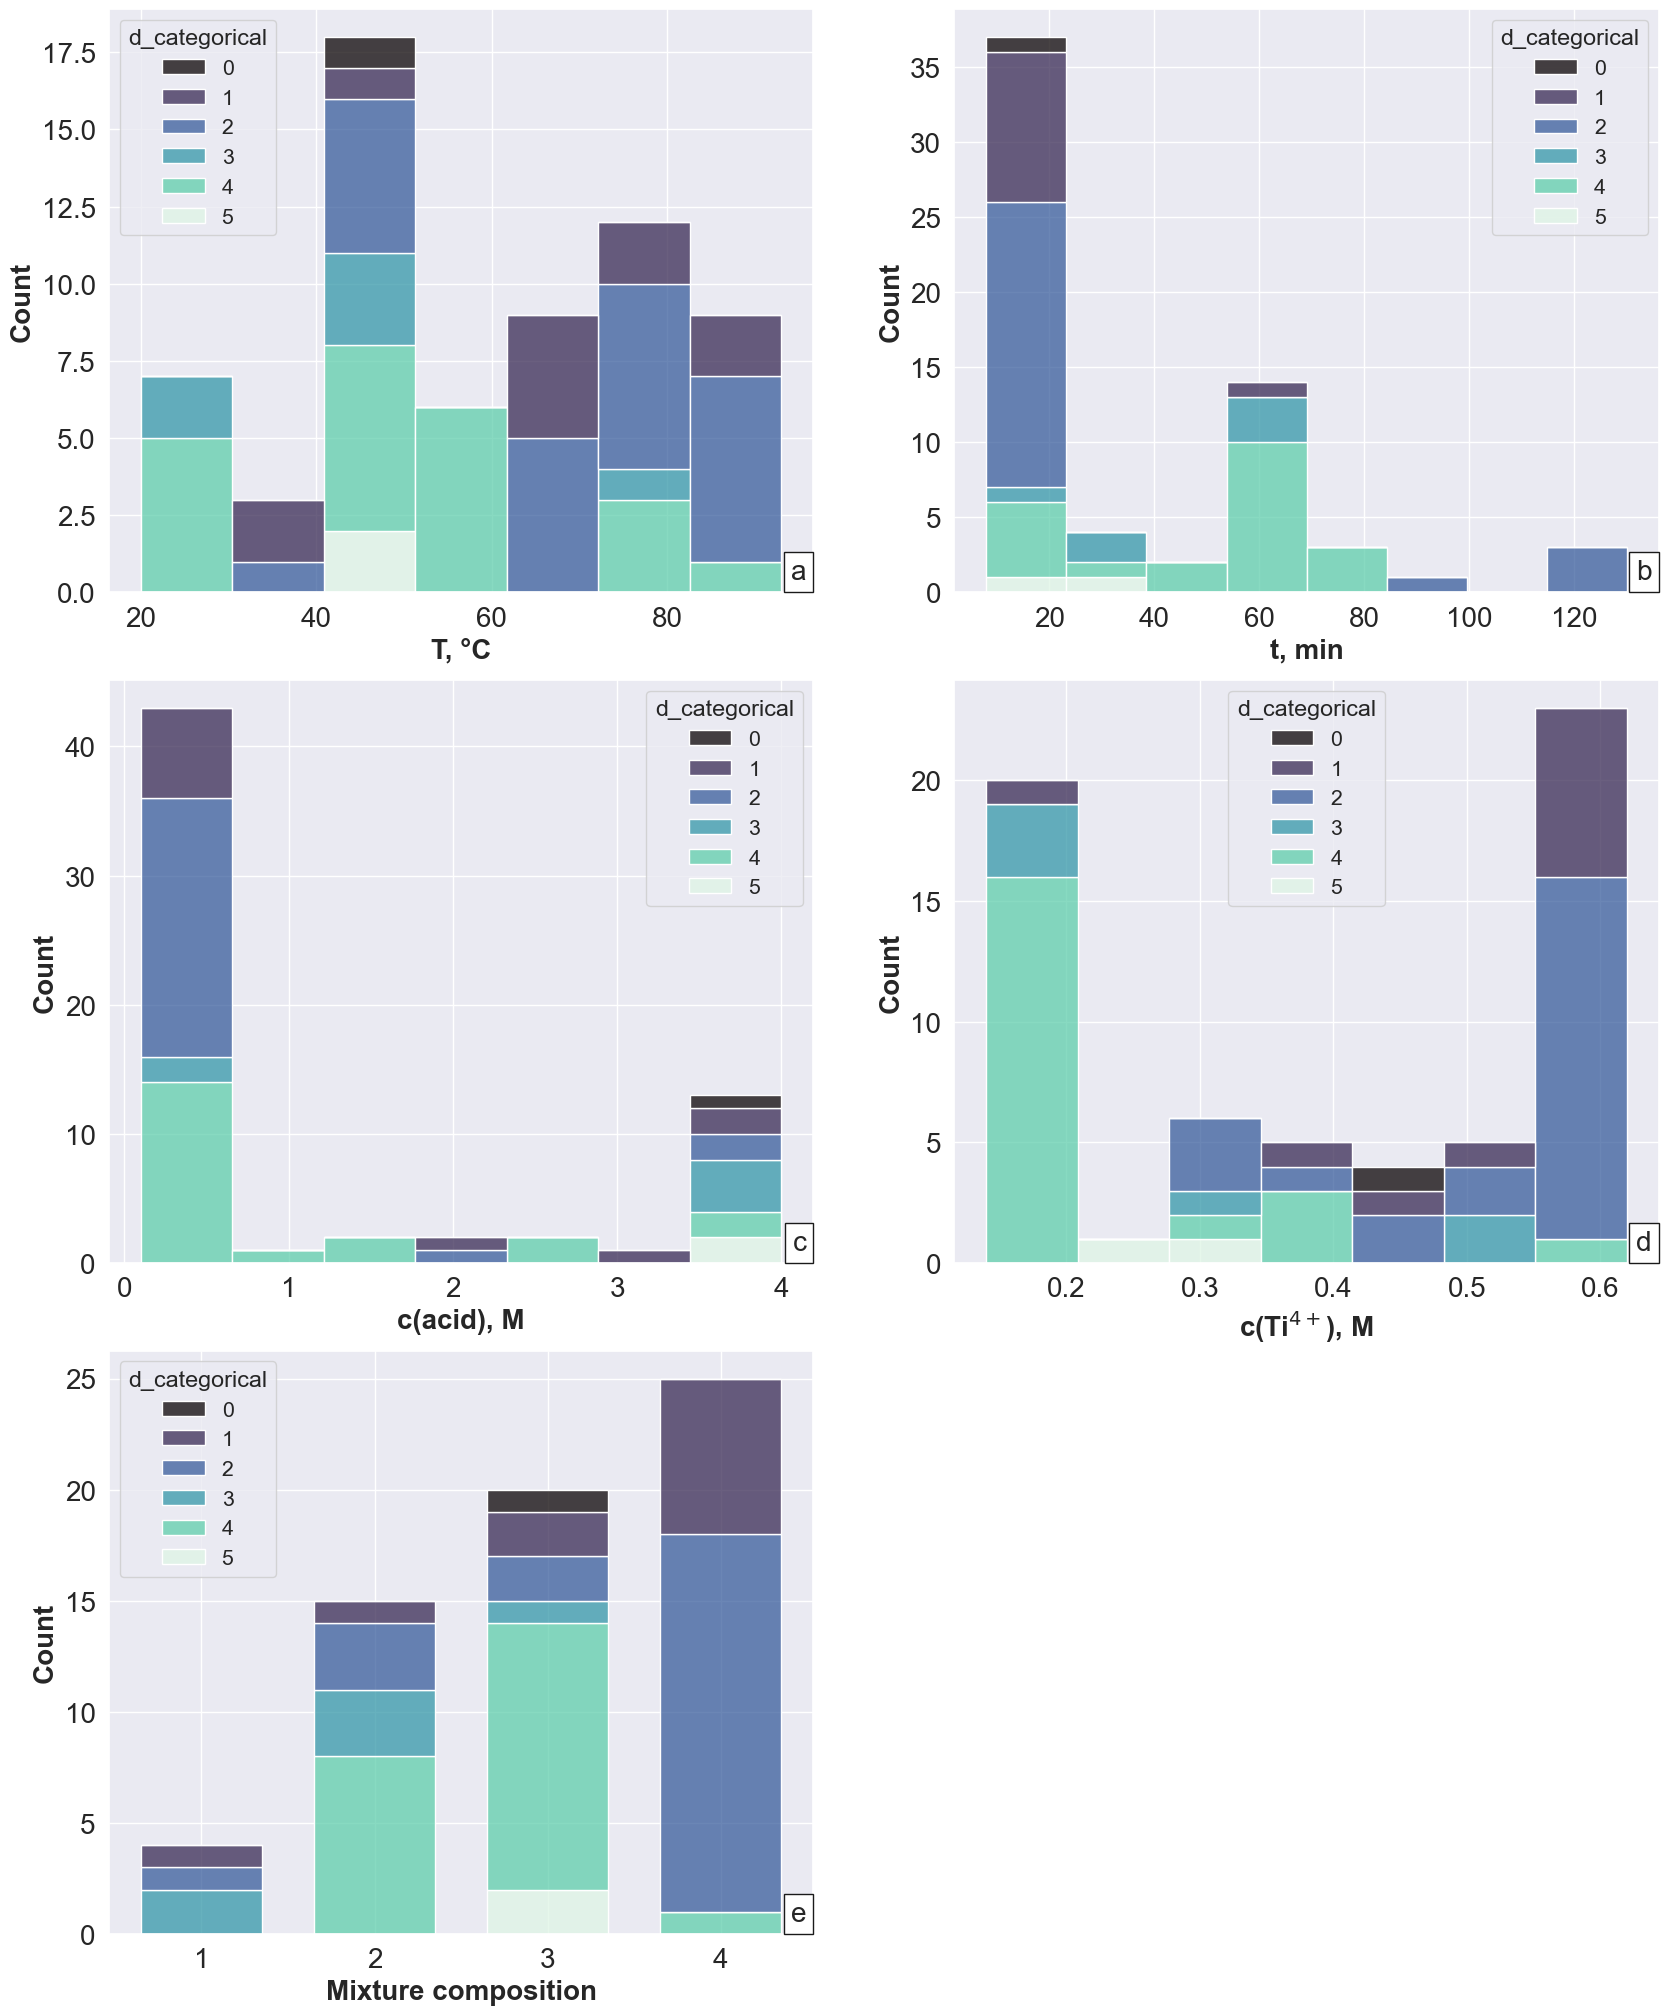

In [13]:
draw_hists(df, 'd_categorical', 'distibution_with_d_categorical')

In [14]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 20:
        return "< 20"
    else:
        return str(x)

df_plot['Stability of sols, days'] = df_plot['Stability of sols, days'].apply(replace_func_days)

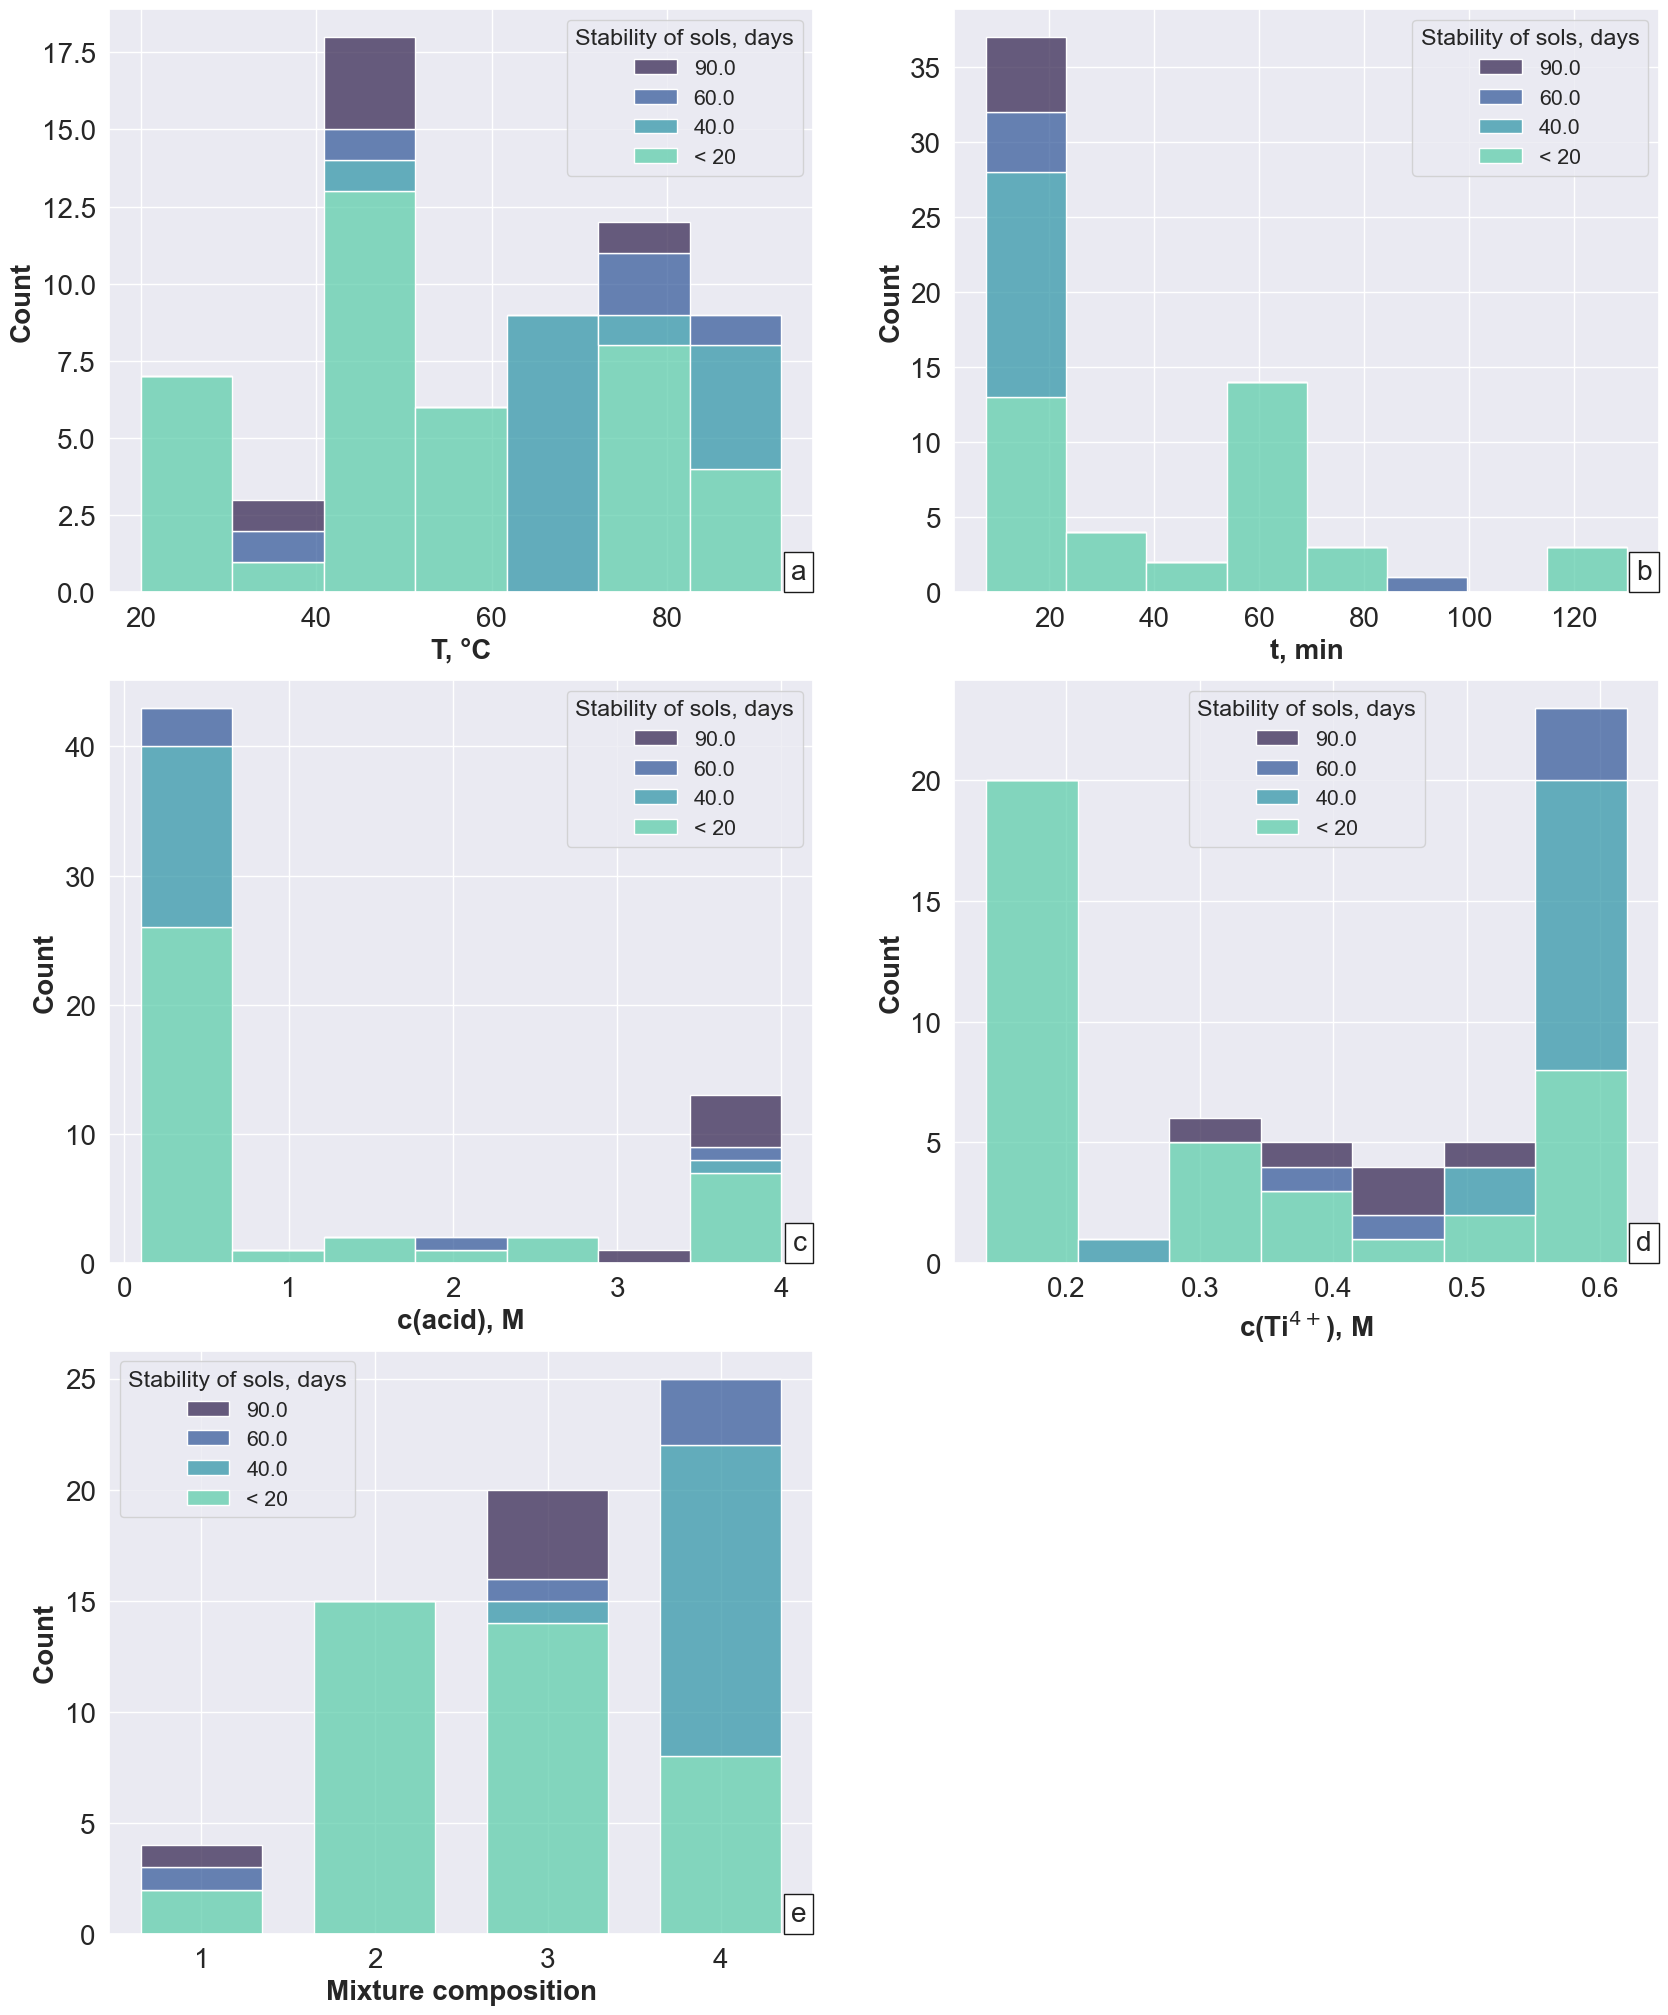

In [15]:
hue_order =['90.0', '60.0', '40.0', '< 20']
draw_hists(df_plot, 'Stability of sols, days', 'distibution_with_stability_days', hue_order=hue_order)

In [16]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 96:
        return "< 96"
    else:
        return str(x)

df_plot['Contents, %'] = df_plot['Contents, %'].apply(replace_func_days)

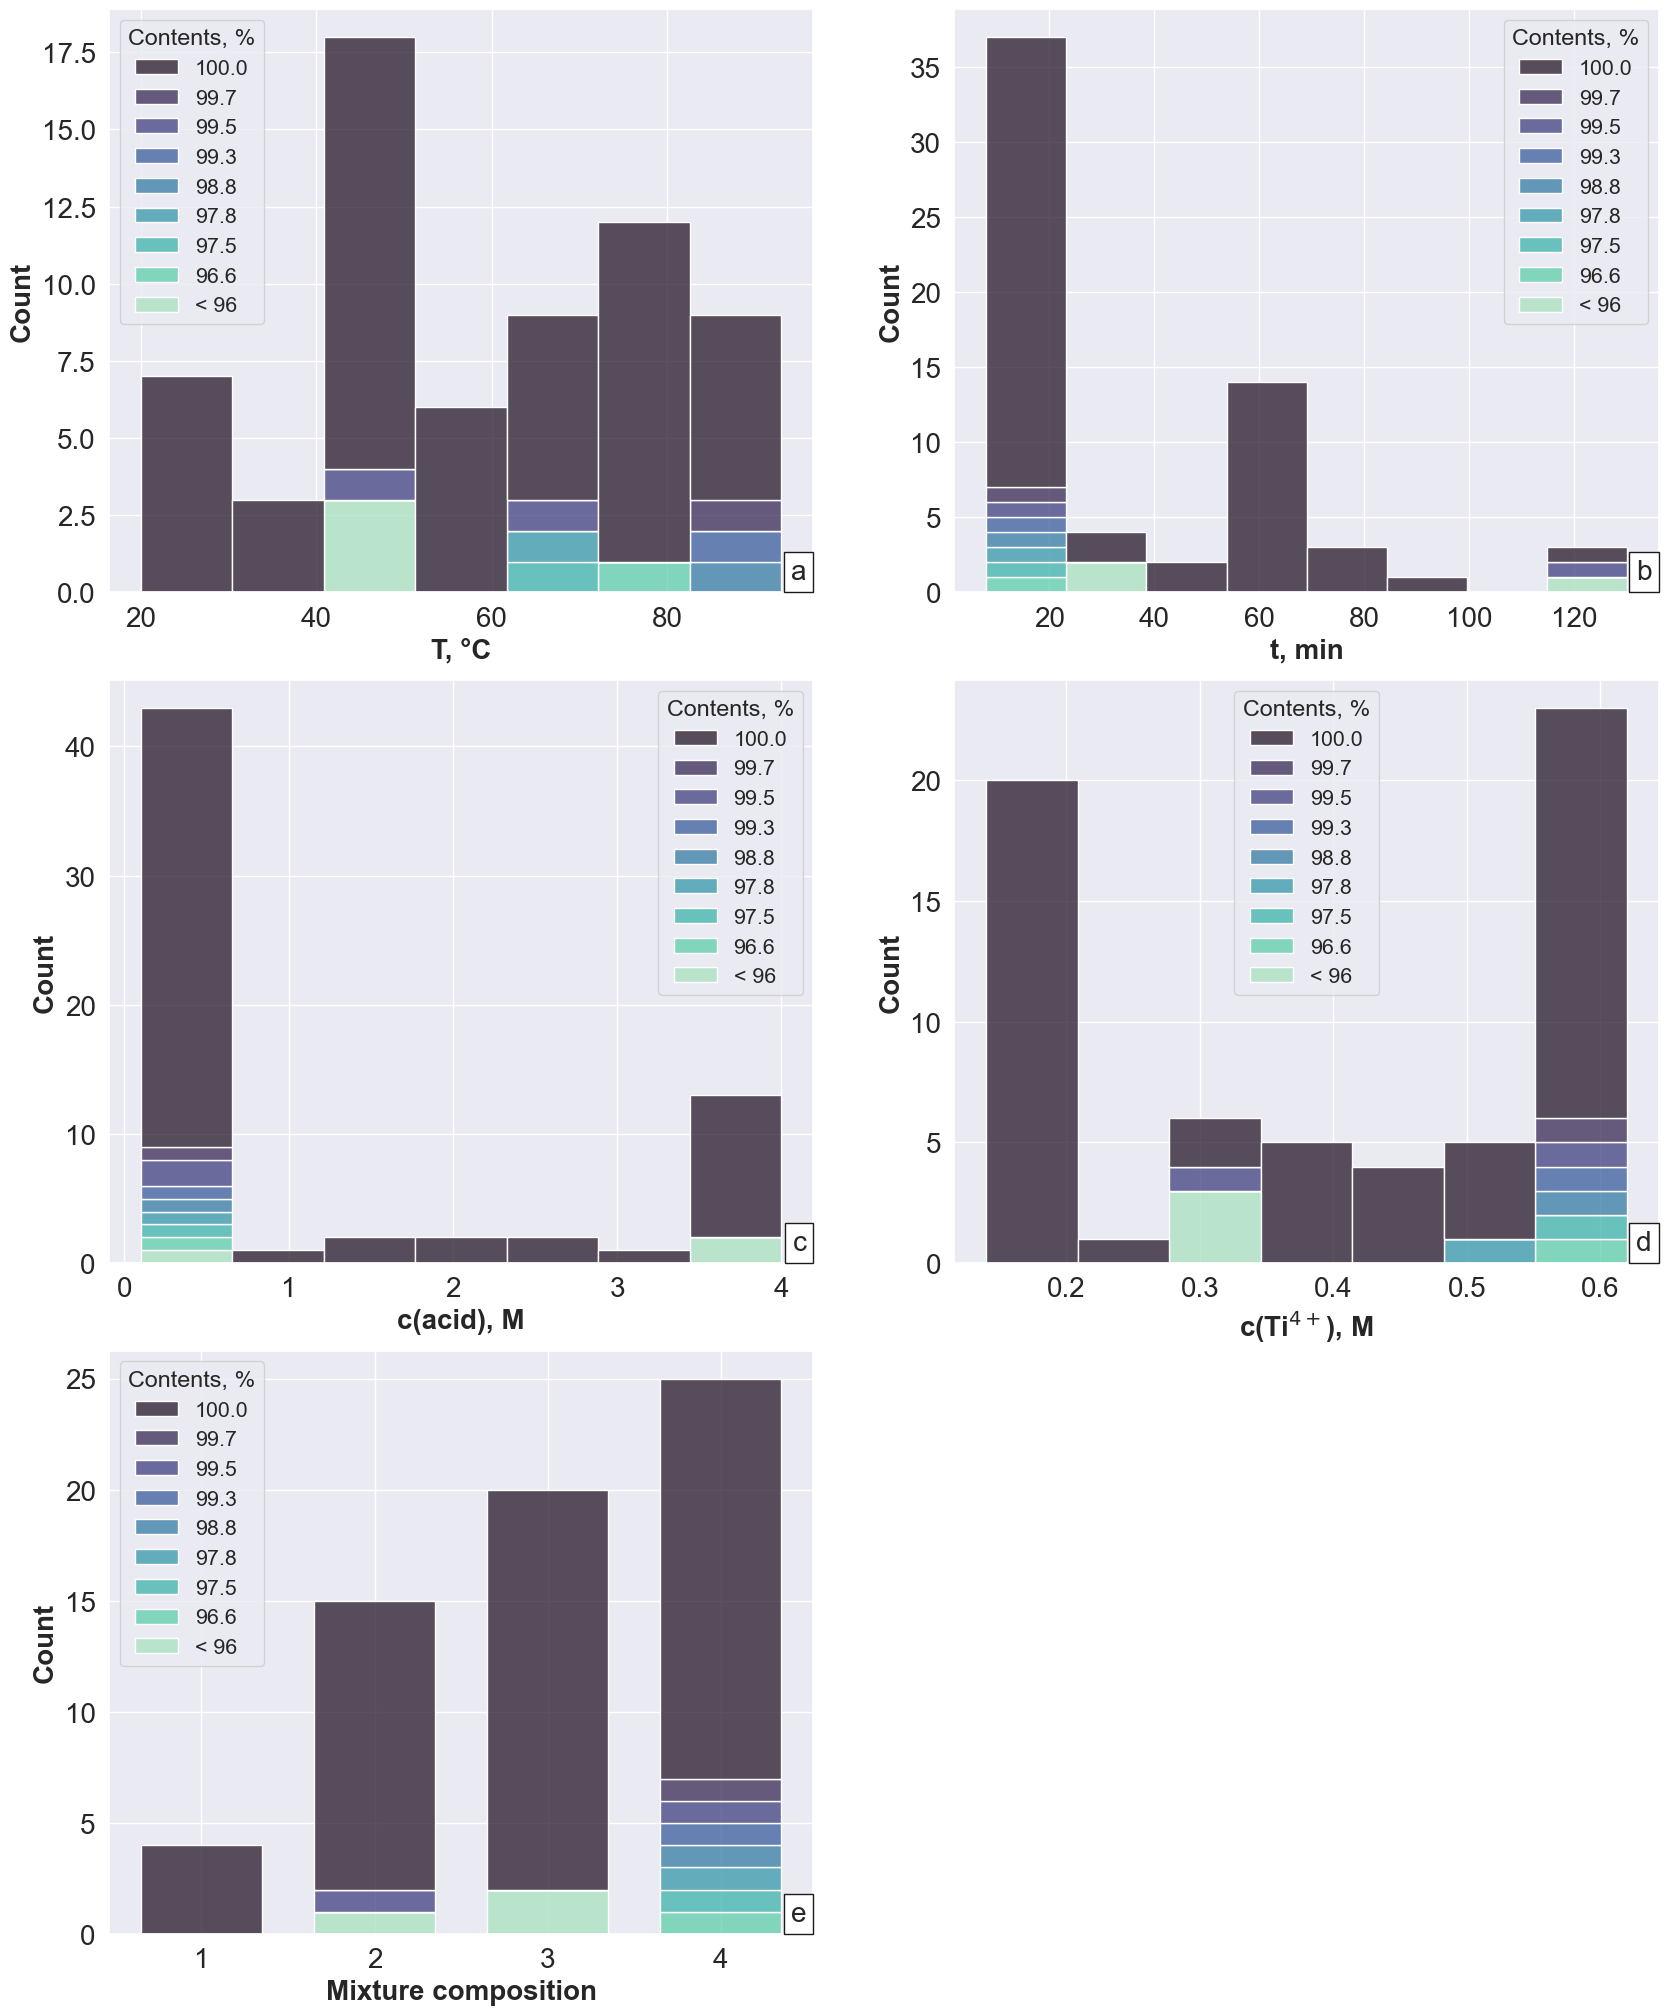

In [17]:
hue_order=['100.0', '99.7', '99.5',  '99.3',  '98.8', '97.8', '97.5', '96.6', '< 96']
draw_hists(df_plot, 'Contents, %', 'distibution_with_contents', hue_order=hue_order)

## Linear regression for coafitionts predictions

In [24]:
X_nsga = X.drop("Mixture composition", axis=1)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X_nsga, y_days)
best_linear_regression_days = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_days.coef_)

-17.509456726679357
{'fit_intercept': False}
[-0.24062754 -0.11465792  7.24046035 88.52941832]


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_nsga, y_d)
best_linear_regression_d = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_d.coef_)

-442.6472883032924
{'fit_intercept': True}
[  10.49632682 -301.16170726 -130.12804994 -942.71051433]


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X_nsga, y_content)
best_linear_regression_content = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_content.coef_)

-8.559373159149226
{'fit_intercept': True}
[ -0.15652931  -0.25471467  -2.39097469 -11.33128964]


## Optimisation with NSGA2 algorithm

In [28]:
class SoleProblem(ElementwiseProblem):
    def __init__(self, coefs):
        self.coefs = coefs
        super().__init__(n_var=4, n_obj=3, n_ieq_constr=4,
                         xl=np.array([20, 1, 0.1, 0.14]),
                         xu=np.array([80, 130, 5, 1.5]) )

    def _evaluate(self, x, out, *args, **kwargs):
        fs = []
        gs = []
        for coef in self.coefs:
            f = coef[-1]
            for i in range(0, len(coef) - 1):
                f += x[i] * coef[i]    
            fs.append(f)
        out["F"] = fs
        out["G"] = [fs[0], -fs[1] + 0.7, fs[2], -fs[2] - 100]


problem = SoleProblem(
    [-np.append(best_linear_regression_days.coef_, best_linear_regression_days.intercept_),
     np.append(best_linear_regression_d.coef_, best_linear_regression_d.intercept_),
     -np.append(best_linear_regression_content.coef_, best_linear_regression_content.intercept_)
    ])

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ("n_gen", 500),
               verbose=False,
               seed=1)

In [29]:
for f, x in zip(res.F, res.X):
    print(f'For getting stability days = {round(-f[0], 3)}, diameter = {round(f[1], 3)} and content = {round(-f[2], 3)} use:')
    print(f'\ttemperature = {round(x[0], 3)}')
    print(f'\ttime = {round(x[1], 3)}')
    print(f'\tc(acid) = {round(x[2], 3)}')
    print(f'\tc(Ti) = {round(x[3], 3)}')

For getting stability days = 87.219, diameter = 7.476 and content = 100.0 use:
	temperature = 57.105
	time = 1.0
	c(acid) = 0.1
	c(Ti) = 1.134
For getting stability days = 104.791, diameter = 0.732 and content = 93.492 use:
	temperature = 79.839
	time = 1.0
	c(acid) = 0.1
	c(Ti) = 1.394
For getting stability days = 86.9, diameter = 4.016 and content = 100.0 use:
	temperature = 56.785
	time = 1.002
	c(acid) = 0.169
	c(Ti) = 1.123
For getting stability days = 86.9, diameter = 4.113 and content = 100.0 use:
	temperature = 56.785
	time = 1.002
	c(acid) = 0.169
	c(Ti) = 1.123
For getting stability days = 104.634, diameter = 0.7 and content = 93.549 use:
	temperature = 79.641
	time = 1.0
	c(acid) = 0.1
	c(Ti) = 1.391
For getting stability days = 87.295, diameter = 6.483 and content = 99.994 use:
	temperature = 57.084
	time = 1.0
	c(acid) = 0.1
	c(Ti) = 1.134
For getting stability days = 89.147, diameter = 5.537 and content = 99.314 use:
	temperature = 59.449
	time = 1.0
	c(acid) = 0.1
	c(Ti)

## Forests feature importance

### Utils

In [30]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [31]:
from matplotlib.offsetbox import AnchoredText

def draw_importance(importances, model_name, columns=X.columns, ax=None, is_save=False):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    is_save = False
    if ax is None:
        plt.figure(figsize=(20, 10))
        ax = plt.gca()
        is_save = True

    bars = ax.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ax.set_xticks(range(num_to_plot), feature_indices)
    ax.set_xlim([-1, num_to_plot])
    ax.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize=20)
    # ax.set_title(f"Feature importance in {model_name}", fontsize=18)
    ax.tick_params(axis='both', labelsize=22)
    if is_save:
        plt.savefig(f'{artifacts_path}{model_name}.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0.1)
        plt.show()
    else:
        txt = AnchoredText(model_name, loc="lower right", pad=0.25, borderpad=0, prop=dict(fontsize="xx-large"))
        ax.add_artist(txt)
    

In [36]:
def learn_random_forest(X, y, name, ax=None, is_save=False):
    parameters = {
        'n_estimators': range(100, 500, 100),
        'max_depth': [None] + list(range(3, 11, 2))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_random_forest = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_random_forest.feature_importances_, f"{name}", ax=ax, is_save=is_save)
    return best_random_forest

In [37]:
def learn_gradient_boosting(X, y, name, ax=None, is_save=False):
    parameters = {
        'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': range(1, 18, 2)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_gradient_boost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_gradient_boost.feature_importances_, f"{name}", ax=ax, is_save=is_save)
    return best_gradient_boost

In [38]:
def learn_xgboost(X, y, name, ax=None, is_save=False):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_xgboost.feature_importances_, f"{name}", ax=ax, is_save=is_save)
    return best_xgboost

### Learning

#### Days of stability

-18.039437845361554
{'max_depth': 3, 'n_estimators': 400}
Feature ranking:
1. с(Ti$^{4+}$), M 0.412926 
2. t, min 0.293165 
3. с(acid), M 0.136039 
4. T, °С 0.135866 
5. Mixture composition 0.022005 
-17.800596512873636
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 128}
Feature ranking:
1. с(Ti$^{4+}$), M 0.346044 
2. t, min 0.334205 
3. с(acid), M 0.254824 
4. T, °С 0.062010 
5. Mixture composition 0.002917 
-16.532414495027982
{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 1.0}
Feature ranking:
1. с(acid), M 0.388694 
2. с(Ti$^{4+}$), M 0.260392 
3. t, min 0.193217 
4. T, °С 0.127304 
5. Mixture composition 0.030392 


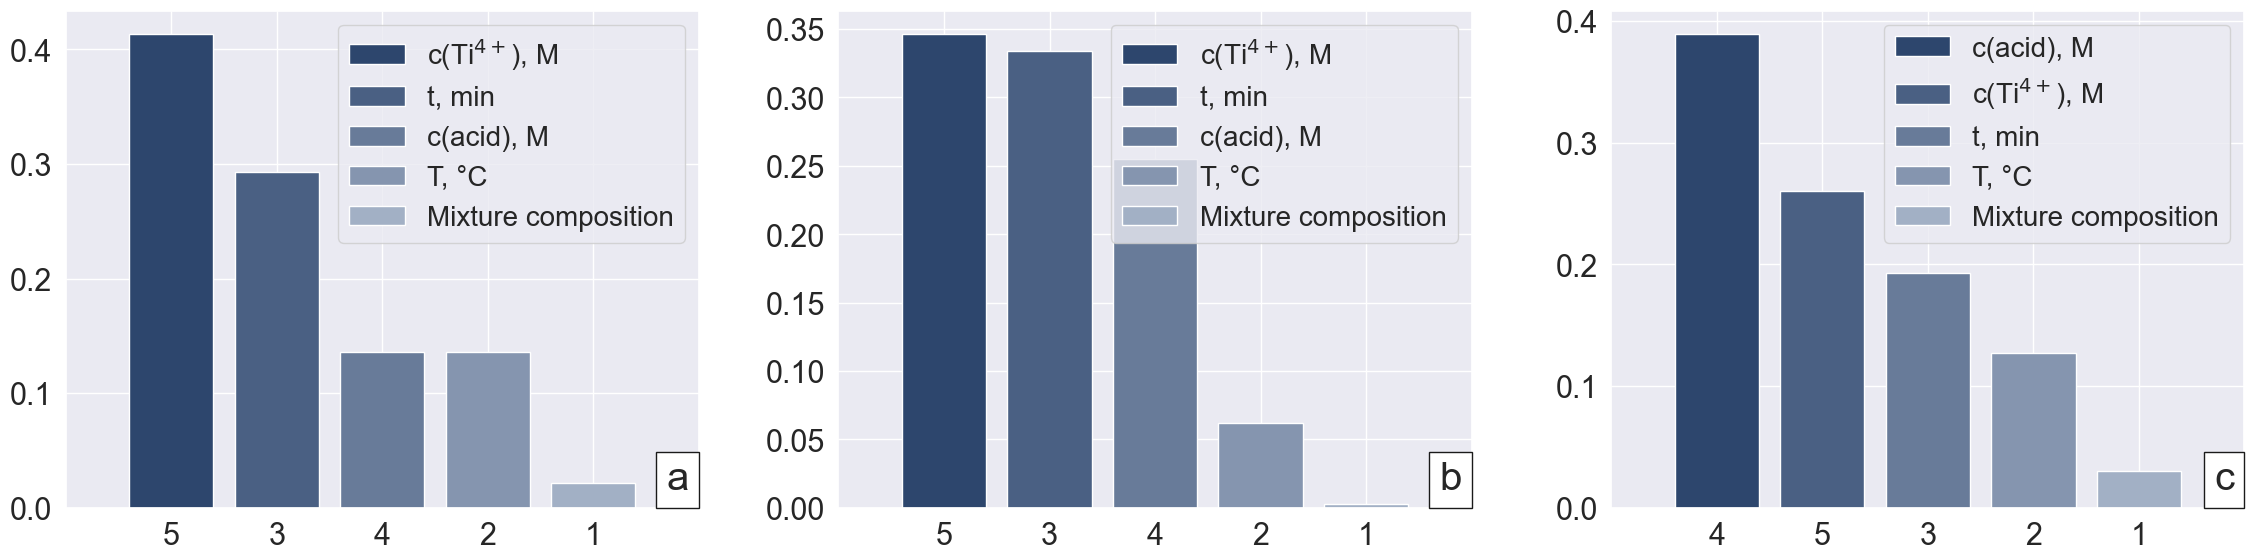

In [39]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(24, 7),
)
fig.tight_layout(pad=3.5)
days_rf = learn_random_forest(X, y_days, "a", ax=axes[0])
days_grad = learn_gradient_boosting(X, y_days, "b", ax=axes[1])
days_xgboost = learn_xgboost(X, y_days, "c", ax=axes[2])
plt.savefig(f'{artifacts_path}_StabilityDays.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0)

#### Diameter of zole

-661.8052523178422
{'max_depth': 5, 'n_estimators': 100}
Feature ranking:
1. с(Ti$^{4+}$), M 0.674041 
2. t, min 0.110658 
3. с(acid), M 0.085458 
4. T, °С 0.082435 
5. Mixture composition 0.047408 
-543.5611157729148
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 4}
Feature ranking:
1. с(Ti$^{4+}$), M 0.871698 
2. с(acid), M 0.079860 
3. t, min 0.048442 
4. T, °С 0.000000 
5. Mixture composition 0.000000 
-481.8229281480838
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
Feature ranking:
1. с(Ti$^{4+}$), M 0.361935 
2. Mixture composition 0.229826 
3. с(acid), M 0.213890 
4. t, min 0.110836 
5. T, °С 0.083513 


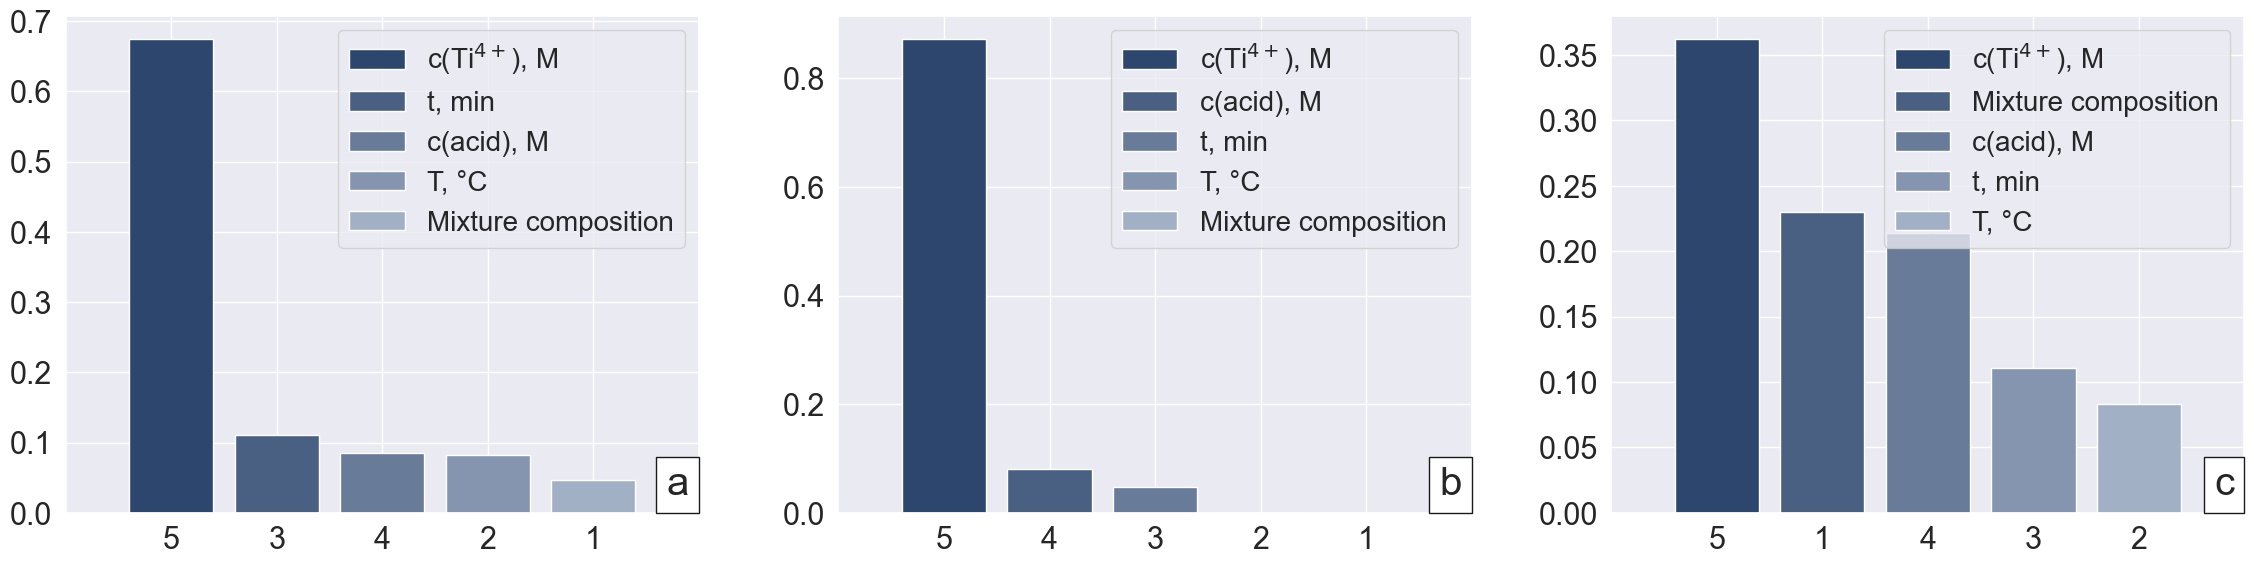

In [40]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(24, 7),
)
fig.tight_layout(pad=3.5)
d_rf = learn_random_forest(X, y_d, "a", ax=axes[0])
d_grad = learn_gradient_boosting(X, y_d, "b", ax=axes[1])
d_xgboost = learn_xgboost(X, y_d, "c", ax=axes[2])
plt.savefig(f'{artifacts_path}_Diameter.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0.1)

#### Content

-8.14104753769669
{'max_depth': 5, 'n_estimators': 400}
Feature ranking:
1. t, min 0.615932 
2. Mixture composition 0.164218 
3. с(acid), M 0.084814 
4. с(Ti$^{4+}$), M 0.070477 
5. T, °С 0.064560 
-6.0126879249035525
{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 4}
Feature ranking:
1. t, min 1.000000 
2. с(Ti$^{4+}$), M 0.000000 
3. с(acid), M 0.000000 
4. T, °С 0.000000 
5. Mixture composition 0.000000 
-6.338543208195613
{'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
Feature ranking:
1. t, min 0.369966 
2. Mixture composition 0.218795 
3. с(Ti$^{4+}$), M 0.189926 
4. T, °С 0.178186 
5. с(acid), M 0.043127 


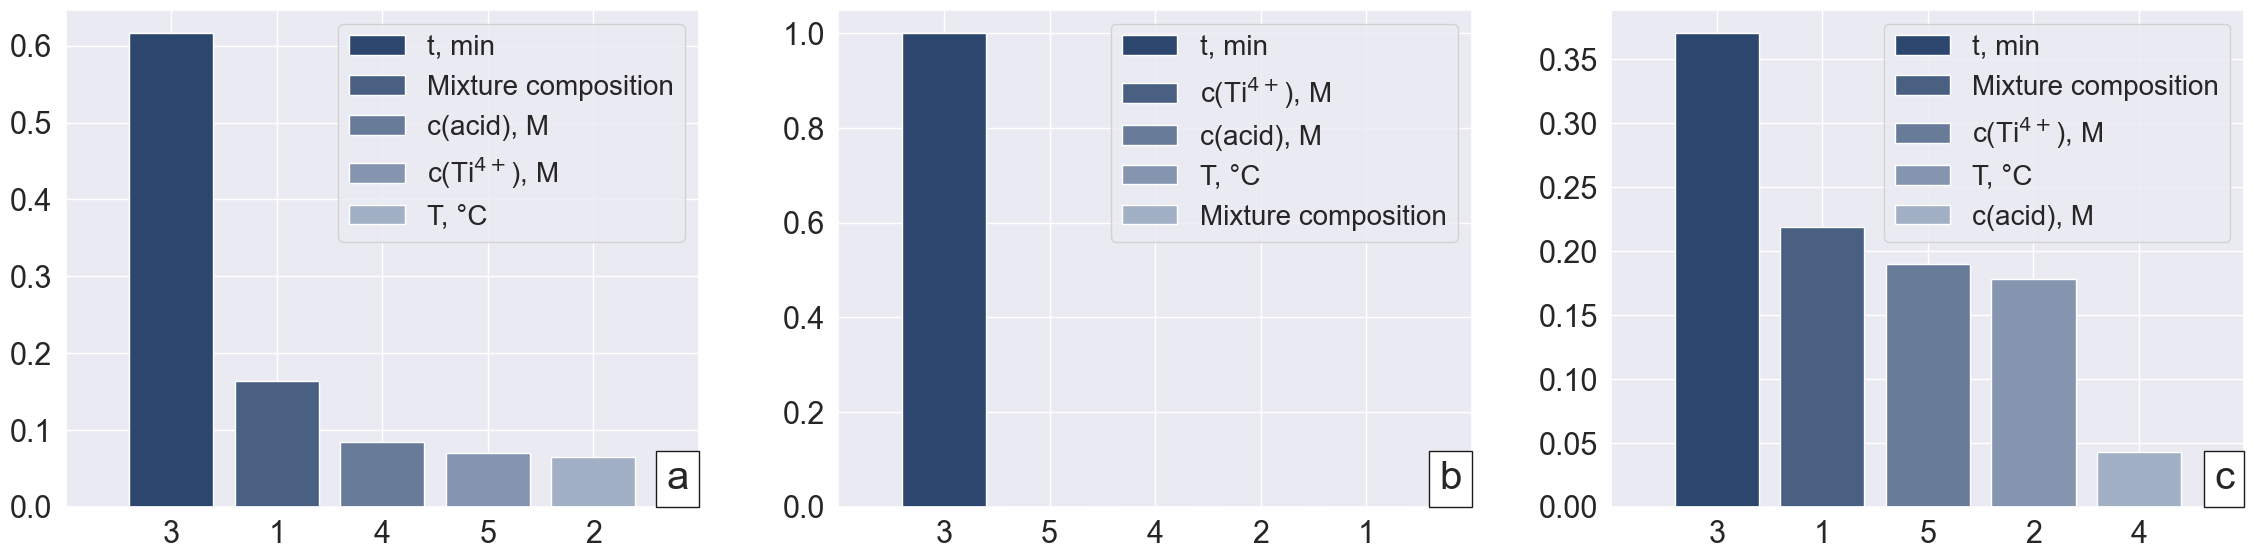

In [41]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(24, 7),
)
fig.tight_layout(pad=3.5)
content_rf = learn_random_forest(X, y_content, "a", ax=axes[0])
content_grad = learn_gradient_boosting(X, y_content, "b", ax=axes[1])
content_xgboost = learn_xgboost(X, y_content, "c", ax=axes[2])
plt.savefig(f'{artifacts_path}_Content.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0)

## SHAP Explanation

### Utils

In [42]:
def explain(model, X=X, name="model", is_save=False, color_bar=False):
    X = X.rename(columns={'Composition mixtures': 'Com. mix.'})
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, plot_size=[10, 6], s=26, show=False, color_bar=color_bar)
    if is_save:
        plt.tick_params(axis='both', labelsize=16)
        plt.savefig(f'{artifacts_path}{name} shap.png', bbox_inches='tight')
        plt.show()

### Explain

#### Days of stability

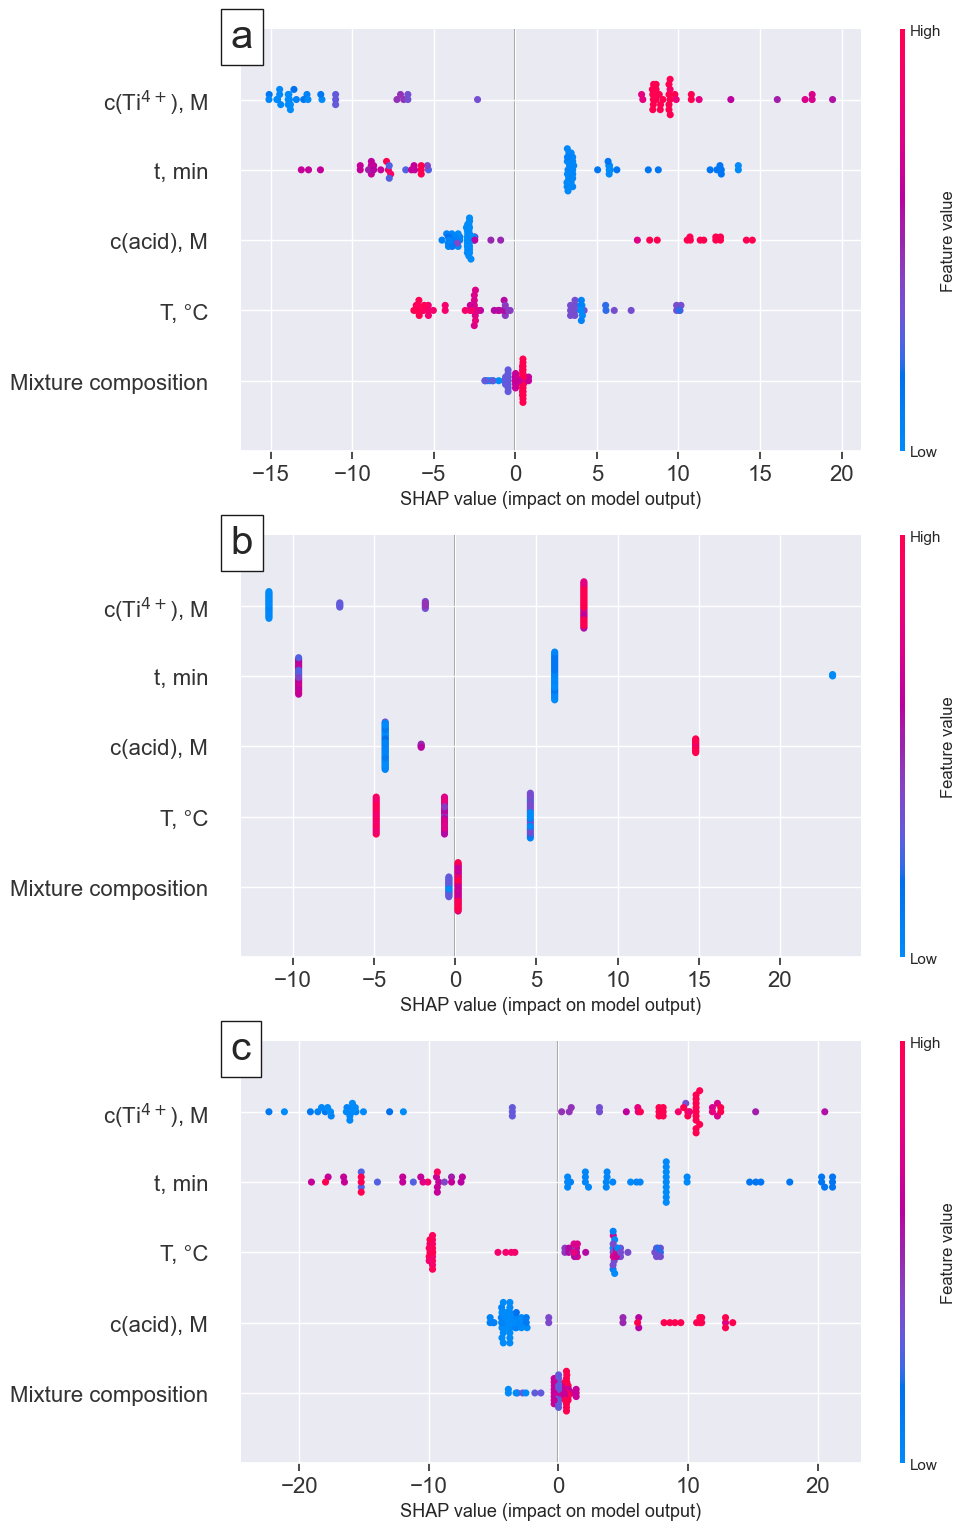

In [43]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
txt = AnchoredText("a", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(days_rf, name="RandomForest, days of stability", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 2)
txt = AnchoredText("b", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(days_grad, name="GradientBoosting, days of stability", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 3)
txt = AnchoredText("c", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(days_xgboost, name="XGBoost, days of stability", color_bar=True)
plt.subplots_adjust( 
    top=2.5
)
plt.tick_params(axis='both', labelsize=16)
plt.savefig(f'{artifacts_path}Stability shap.png', bbox_inches='tight')

#### Diameter of zole

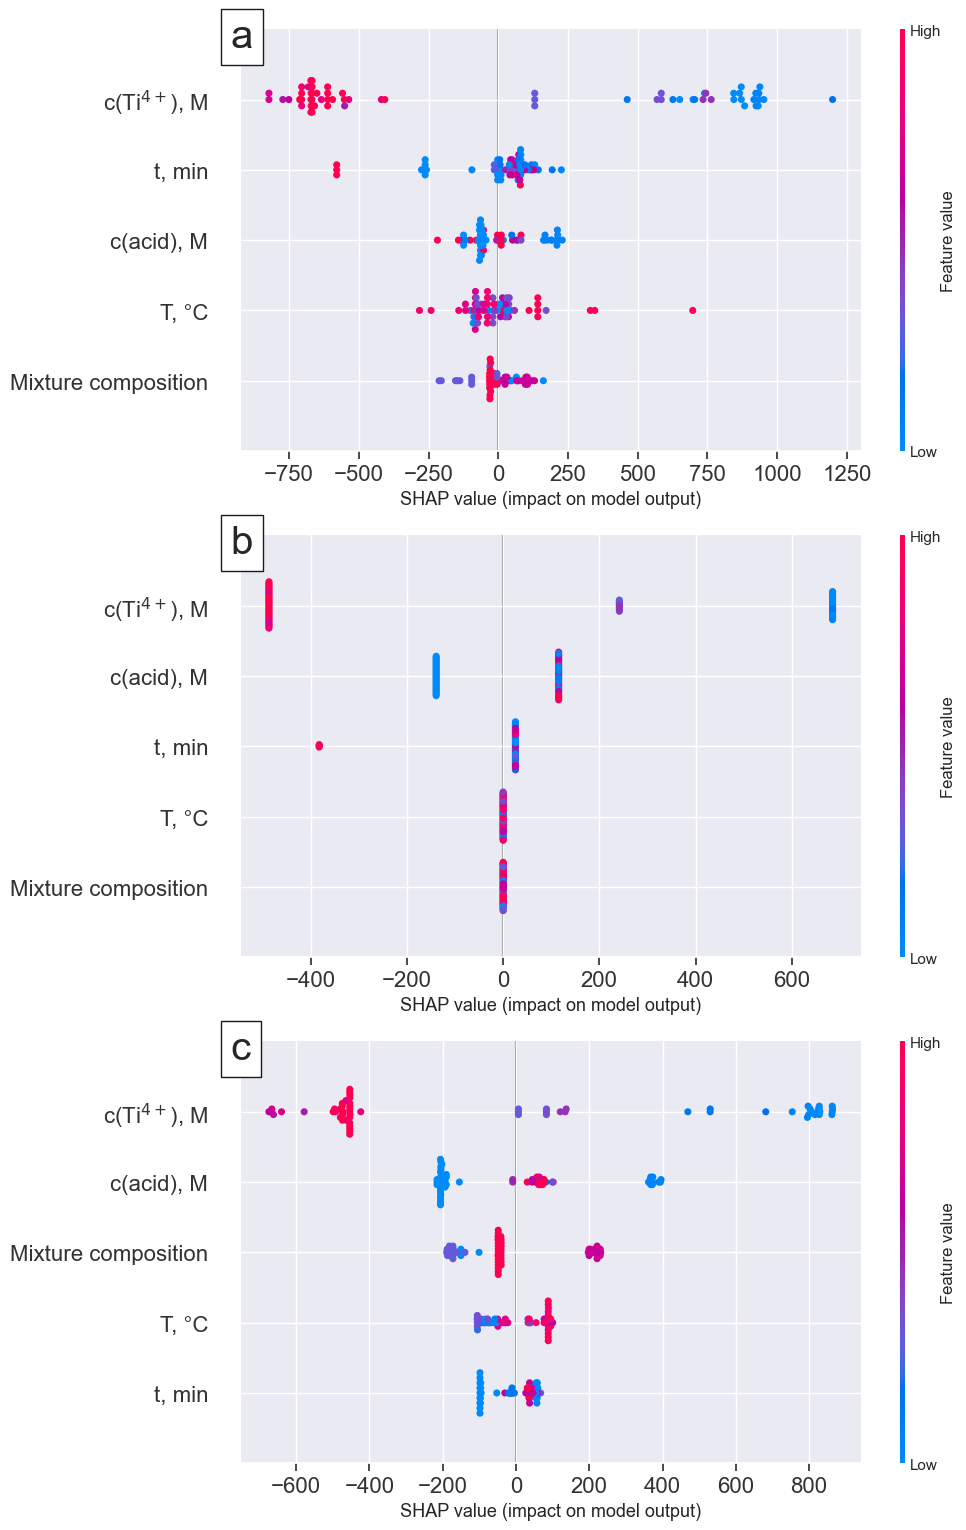

In [44]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
txt = AnchoredText("a", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_rf, name="RandomForest, diameter", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 2)
txt = AnchoredText("b", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_grad, name="GradientBoosting, diameter", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 3)
txt = AnchoredText("c", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_xgboost, name="XGBoost, diameter", color_bar=True)
plt.subplots_adjust( 
    top=2.5
)
plt.tick_params(axis='both', labelsize=16)

plt.savefig(f'{artifacts_path}Diameter shap.png', bbox_inches='tight')

#### Content

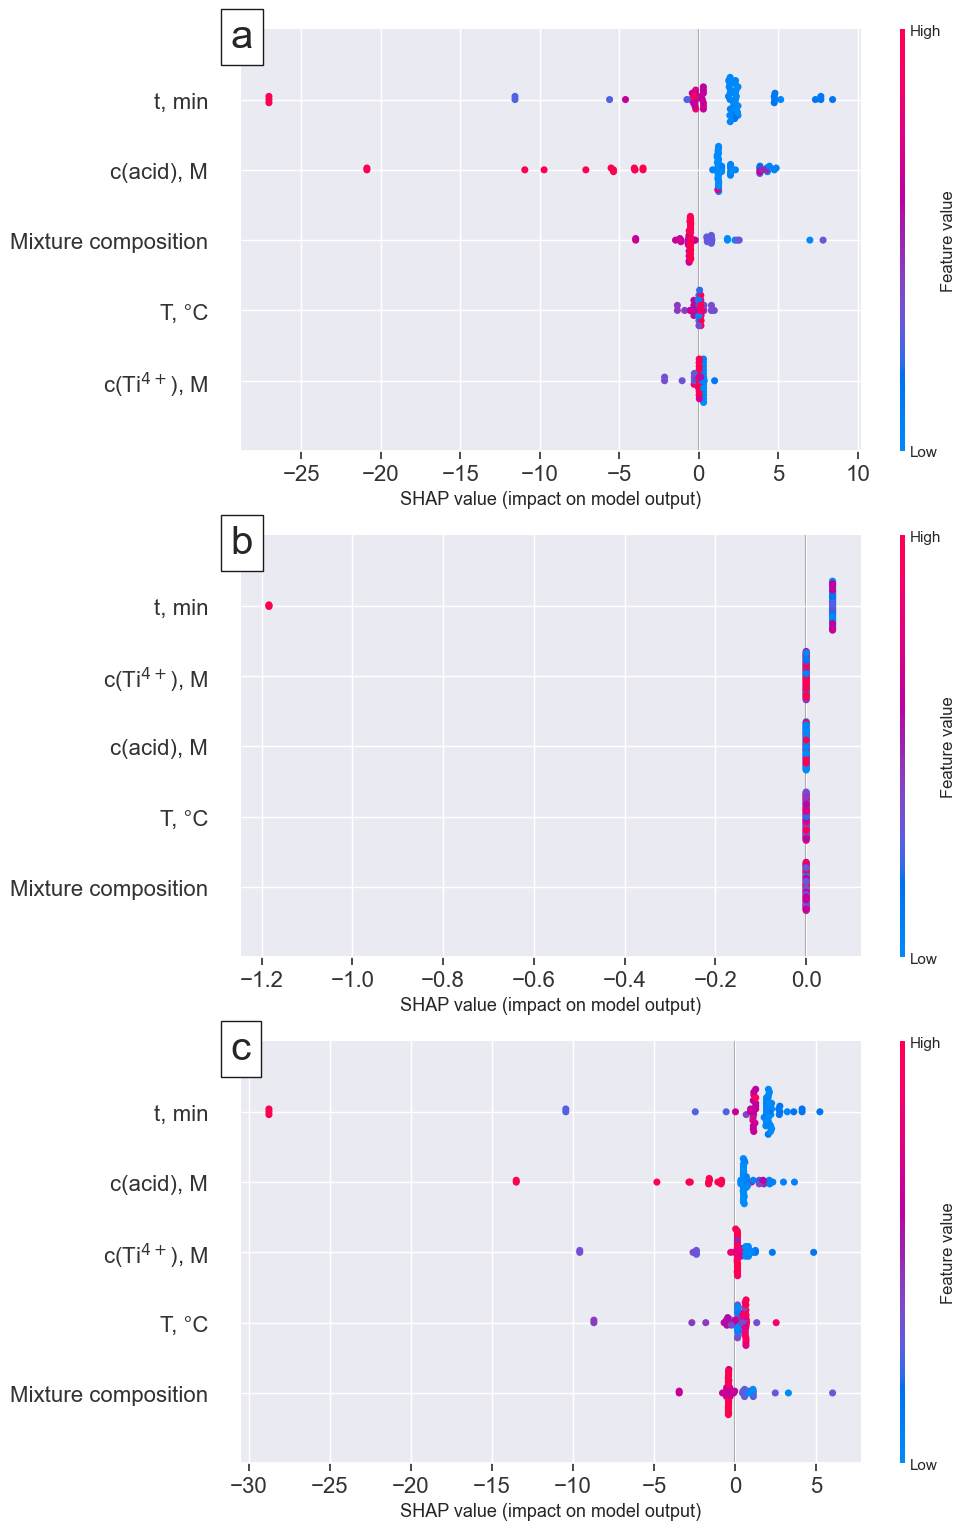

In [46]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
txt = AnchoredText("a", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(content_rf, name="RandomForest, content", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 2)
txt = AnchoredText("b", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(content_grad, name="GradientBoosting, content", color_bar=True)
plt.tick_params(axis='both', labelsize=16)
plt.subplot(3, 1, 3)
txt = AnchoredText("c", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(content_xgboost, name="XGBoost, content", color_bar=True)
plt.subplots_adjust( 
    top=2.5
)
plt.tick_params(axis='both', labelsize=16)

plt.savefig(f'{artifacts_path}Content shap.png', bbox_inches='tight')